#  Прогнозирование заказов такси

**Краткая суть**

Необходимо построить модель, которая будет прогнозировать количество заказов такси на следующий час

**Описание**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.


**Критерии оценки модели**

* Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**План выполнения проекта**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error, make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn import linear_model

from statsmodels.tsa.stattools import adfuller

import warnings
import time

warnings.filterwarnings('ignore')

## Подготовка

### Посмотрим на данные

In [2]:
virtual = '/datasets/taxi.csv'
local = '.../datasets/taxi.csv'

if os.path.exists(virtual):
    df = pd.read_csv(virtual, index_col=[0], parse_dates=[0])
elif os.path.exists(local):
    df = pd.read_csv(local, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [3]:
df.sort_index(inplace=True)

In [4]:
def check_data(data):
    print('')
    print('')
    print('Информация о файле')
    print('')
    df.info()
    print('')
    print('')
    print('Первые 5 строк файла')
    display(df.head())
    print('')
    print('')
    print('Количество пропусков')
    display(df.isna().sum())
    print('')
    print('')
    print('Количество дубликатов')
    display(df.index.duplicated().sum())
    print('')

In [5]:
check_data(df)



Информация о файле

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Первые 5 строк файла


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




Количество пропусков


num_orders    0
dtype: int64



Количество дубликатов


0

In [6]:
df = df.resample('1H').sum()

In [7]:
check_data(df)



Информация о файле

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Первые 5 строк файла


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43




Количество пропусков


num_orders    0
dtype: int64



Количество дубликатов


0

Мы выгрузили данные, изначально в которых было 26496 строк и 2 столбца (дата и количество заказов в каждые 10 мин). Столбец *datetime* мы привели к формату *даты*, не забыв приравнять индексы. Затем сделали ресемплирование по одному часу, в результате чего количество строк уменьшилось до 4416.
- Получившийся датафрейм отражает количетсов заказов в каждый час каждого дня 

## Анализ

### Посмотрим на скользящее среднее количество заказов в месяц

In [8]:
pic = df.copy()
pic = pic['2018-03':'2018-08'].resample('1D').sum()
pic['mean'] = pic['num_orders'].rolling(30).mean()  #сглаженное скользящее среднее 
pic['std'] = pic['num_orders'].rolling(30).std() #сглаженное скользящее стандартное отклонение

<Figure size 1296x1440 with 0 Axes>

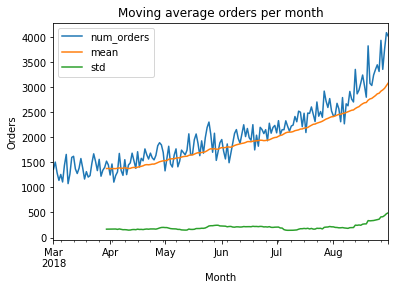

In [9]:
plt.figure(figsize=(18,20))
pic.plot()
plt.title("Moving average orders per month")
plt.xlabel("Month")
plt.ylabel("Orders")
plt.show()

Как можем заметить, количество средних заказов растет на протяжении всего диапазона времени, также изменяется сглаженное скользящее среднее, а это означает что у нас нестационарный ряд. Его прогнозировать сложнее, но мы всё же попытаемся

### Разложим данные на тренд и сезонную компоненту. Рассмотрим апрель 2018 года

In [10]:
decomposed = seasonal_decompose(df)

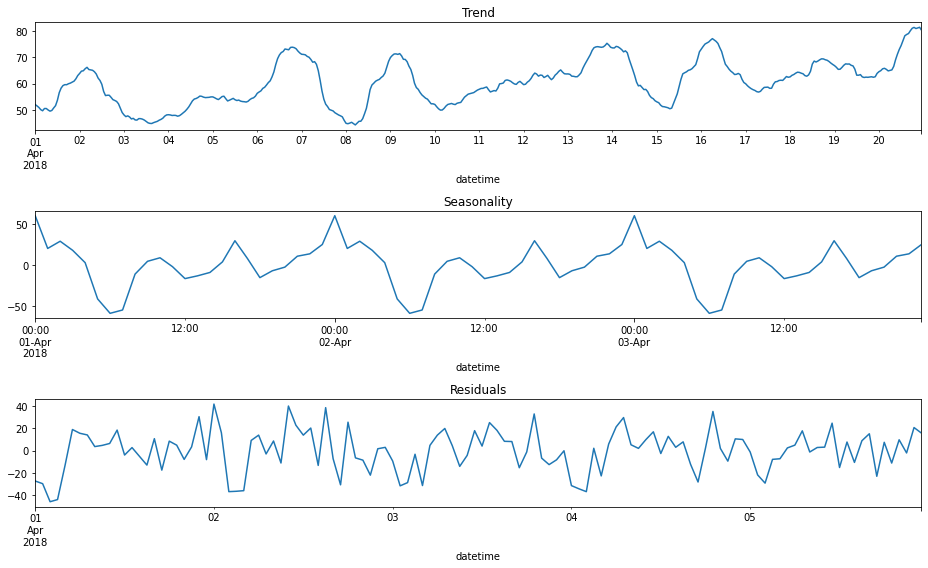

In [11]:
plt.figure(figsize=(13, 8))
plt.subplot(311)

decomposed.trend['2018-04-01':'2018-04-20'].plot(ax=plt.gca()) # отображает 20 дней
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca()) # отображает 3 дня
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid['2018-04-01':'2018-04-05'].plot(ax=plt.gca()) # отображает 5 дней
plt.title('Residuals')
plt.tight_layout()

- здесь мы видим, что тенденция пиков у нас ***дневная***
- пики приходятся на пятницу-субботу
- спады приходятся на воскресенье-понедельник
- такая тенденция обуславливается тем, что, например кто-то улеатет отдыхать на выходные, кто-то наоборот возвращается из отдыха/командировок. А вот в воскресенье редко кто что-то планирует.
- если посмотреть на график сезонности в диапазоне 3 дня, то можно заметить, что рост заказов начинается с 6 вечера и пик приходится на 00:00, затем идет спад, и в 06:00 утра мы наблюдаем "штиль", что тоже достаточно логично. Улетая/возвращаясь люди планируют вечернее время.
- на графике остатков наблюдается разброс - перед нами нестационарный ряд

### Оценим стационарность ряда с помощью теста Дики-Фуллера

In [12]:
adfuller(df)

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

In [13]:
test_1 = adfuller(df['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % test_1[0])

print('P-значение: %f' % test_1[1])

print('Критические значения:')

for key, value in test_1[4].items():
    print('\t%s: %.3f' % (key, value))
if test_1[0] < test_1[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


In [14]:
test_5 = adfuller(df['num_orders'], autolag = 'AIC')

print('Критерий ADF: %f' % test_5[0])

print('P-значение: %f' % test_5[1])

print('Критические значения:')

for key, value in test_5[4].items():
    print('\t%s: %.3f' % (key, value))
if test_5[0] > test_5[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд стационарен


**После анализа мы выявили:**
- пики заказов такси приходятся на выходной день - субботу
- спады заказов приходятся на понедельник
- временной ряд не стационарен

## Обучение

### Создадим функцию для подсчёта метрики

In [15]:
RMSE = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

### Создадим фичи для моделей

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    new_df = data.copy()
    new_df['day'] = new_df.index.day # добавим день
    new_df['dayofweek'] = new_df.index.dayofweek # добавим день недели
    new_df['hour'] = new_df.index.hour # добавим час
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag) # добавим отстающее значение
    
    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean() # добавим скользящее среднее
    return new_df

In [17]:
new_df = make_features(df, 24, 24)

In [18]:
new_df.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы создали в ручную фичи для моделей. Избавимся от строк , в которых есть **NaN'ы**, т к мы не можем их заполнить, поскольку работаем с ***временным рядом***. 

In [19]:
new_df.dropna(inplace=True)

### Определим features и target. Разделим данные на обучающую и тестовую выборки. 

In [20]:
features, target = new_df.drop(['num_orders'], axis=1), new_df['num_orders']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1, random_state=22) 

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3952, 28), (440, 28), (3952,), (440,))

Данные разделили, **shuffle=False** потому что важно сохранить последовательность

### Нормализуем данные с помощью StandardScaler

In [23]:
ss = StandardScaler()

In [24]:
X_train_ss = ss.fit_transform(X_train)

### Инизиализируем помощника для кросс-валидации временных рядов

In [25]:
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

### RandomForestRegressor

In [26]:
rfr = RandomForestRegressor(random_state=22)

In [27]:
random_rfr = {'bootstrap': [True, False],
               'max_depth': [None] + [i for i in range(2, 11)], 
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 5, 9],
               'min_samples_split': [2, 7, 13],
               'n_estimators': [130, 284, 22]}

In [28]:
random_rfr= RandomizedSearchCV(estimator = rfr,
                               param_distributions = random_rfr,
                               n_iter = 50,
                               scoring=RMSE,
                               cv = tscv,
                               verbose=2,
                               random_state=22,
                               n_jobs = -1)

In [1]:
%%time
random_rfr.fit(X_train_ss, y_train)
print(random_rfr.best_params_)
print(random_rfr.best_score_)

### Lasso

In [30]:
lasso = linear_model.Lasso(alpha=0.1, random_state=22)

In [31]:
params_lasso = {'alpha':[0.02, 0.03, 0.53, 0.5],
               'tol':[0.01, 0.1, 0.001, 0.0001],
               'random_state':[22]}

In [32]:
random_lasso= RandomizedSearchCV(estimator = lasso,
                               param_distributions = params_lasso,
                               n_iter = 50,
                               scoring=RMSE,
                               cv = tscv,
                               verbose=2,
                               n_jobs = -1)


In [2]:
%%time
random_lasso.fit(X_train_ss, y_train)
print(random_lasso.best_params_)
print(random_lasso.best_score_)

### Ridge

In [34]:
ridge = linear_model.Ridge(alpha=1.0, random_state=22)

In [35]:
params_ridge = {'alpha':[0.02, 0.03, 0.53, 0.5],
               'tol':[0.01, 0.1, 0.001, 0.0001],
               'solver':['auto', 'svd', 'cholesky', 'lsqr'],
               'random_state':[22]}

In [36]:
random_ridge = RandomizedSearchCV(estimator = ridge,
                               param_distributions = params_ridge,
                               n_iter = 50,
                               scoring=RMSE,
                               cv = tscv,
                               verbose=2,
                               n_jobs=-1)

In [4]:
%%time
random_ridge.fit(X_train_ss, y_train)
print(random_ridge.best_params_)
print(random_ridge.best_score_)

### CatBoost

In [38]:
cbr = CatBoostRegressor(random_seed=22)

In [39]:
params_cbr = {'iterations': [1000, 1100, 1200],
              'learning_rate': [0.01, 0.1, 0.001, 1],
              'max_depth': [None] + [i for i in range(2, 11)],              
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [40]:
random_cbr= RandomizedSearchCV(estimator = cbr,
                               param_distributions = params_cbr,
                               scoring=RMSE,
                               cv = tscv,
                               verbose=2,
                               n_jobs = -1)

In [5]:
%%time
random_cbr.fit(X_train_ss, y_train)
print(random_cbr.best_params_)
print(random_cbr.best_score_)

### Соберем все наши значения в таблицу и посмотрим что вышло

In [42]:
result = pd.DataFrame({'model' : ['RandomForestRegressor', 
                                  'Lasso', 
                                  'Ridge', 
                                  'CatBoostRegressor'
                                 ],
                       'RMSE при обучении' : [round(random_rfr.best_score_, 4) * (-1), 
                                              round(random_lasso.best_score_, 4) * (-1), 
                                              round(random_ridge.best_score_, 4) * (-1),
                                              round(random_cbr.best_score_, 4) * (-1)
                                             ]
                      })

In [43]:
result

,model,RMSE при обучении
0,RandomForestRegressor,25.4443
1,Lasso,27.0752
2,Ridge,27.1215
3,CatBoostRegressor,24.4172


**Рейтинг моделей на основе результата**
1. CatBoostRegressor
2. RandomForestRegressor
3. Ridge/Lasso

## Тестирование

### Создадим новую модель и настроим её лучшими параметрами

In [44]:
CatBoostRegressor = CatBoostRegressor(random_seed=22,
                                      iterations=1200,
                                      max_depth=random_cbr.best_params_['max_depth'],
                                      learning_rate=random_cbr.best_params_['learning_rate'],
                                      l2_leaf_reg=random_cbr.best_params_['l2_leaf_reg'])

In [6]:
CatBoostRegressor.fit(X_train_ss, y_train)

### Отмасшабируем наши тестовые данные

In [46]:
X_test_ss = ss.transform(X_test)

### Сделаем предсказание и посмотрим RMSE

In [47]:
pred = CatBoostRegressor.predict(X_test_ss)

In [48]:
score = mean_squared_error(y_test, pred) ** 0.5

In [49]:
print('RMSE на тесте:', round(score, 4))

RMSE на тесте: 41.0983


In [50]:
pred = pd.Series(pred, index=y_test.index)

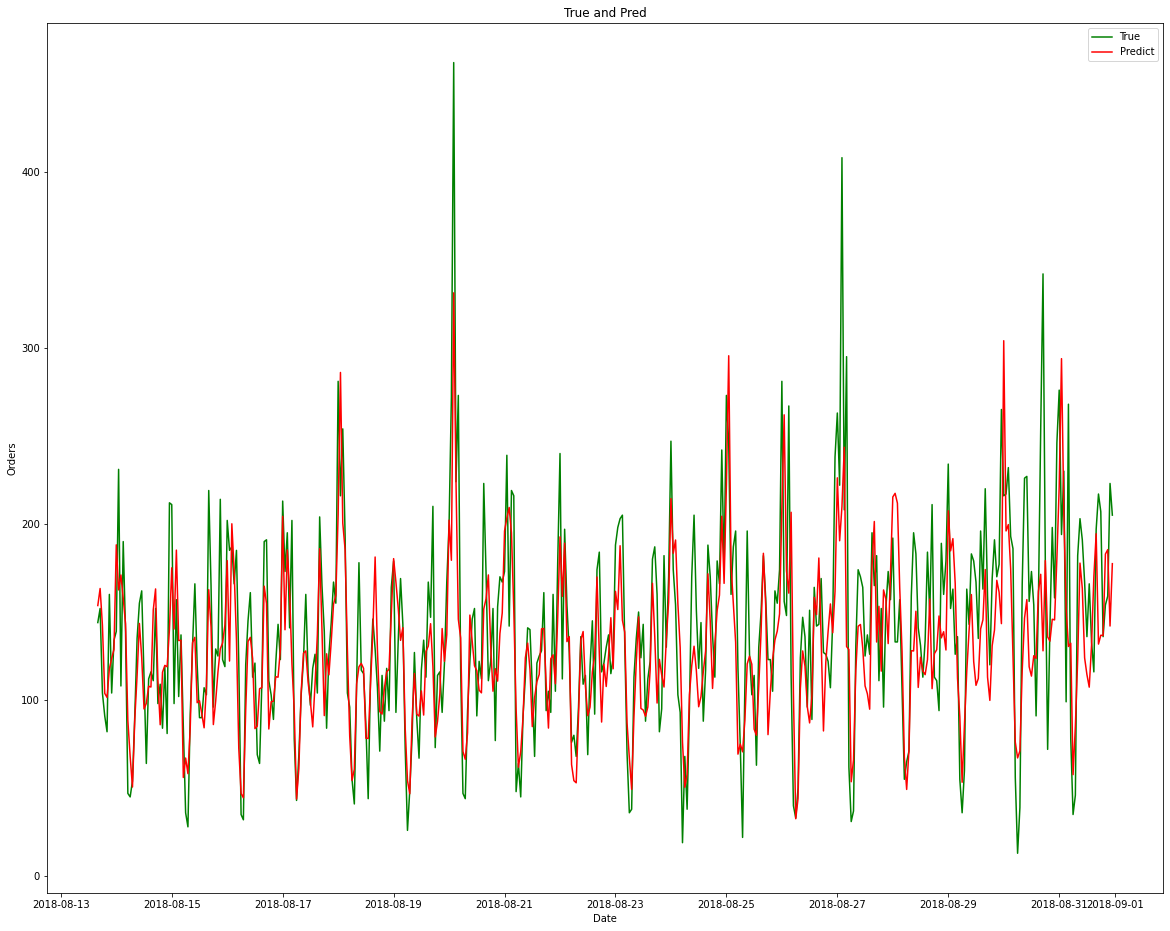

In [51]:
plt.figure(figsize=(20,16))
plt.plot(y_test, label = "True", color='g')
plt.plot(pred, label = "Predict", color='r')
plt.legend()
plt.title("True and Pred")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

CatBoostRegressor ошибается в прогнозировании значений-выбросов, которые могут быть вызваны, например, праздниками

### Сравним метрику RMSE с константной моделью DummyRegressor

In [52]:
dummy = DummyRegressor(strategy="mean")

In [53]:
dummy.fit(X_train_ss, y_train)

DummyRegressor()

In [54]:
predict_dummy = dummy.predict(X_test_ss)

In [55]:
dummy_RMSE = mean_squared_error(y_test, predict_dummy) ** 0.5

In [56]:
print("RMSE константной модели:", round(dummy_RMSE,4))

RMSE константной модели: 84.6877


**Вывод**

1. Нам нужно было построить модель, которая будет прогнозировать количество заказов такси на следующий час
2. На старте у нас был датасет, в котором было 26496 строк и 2 столбца. После нашей обработки количество строк уменьшилось до 4416, получившийся датафрейм отражает количество заказов в каждый час каждого дня.
3. На анализе данных было выявлено что пик заказов приходится на выходные, спад - на понедельник, и что у нас временной ряд не стационарен
4. Мы создали в ручную фичи для моделей. Избавились от строк, значение которых равнялось NaN
5. Были обучены разные модели с разными гиперпараметрами. В результате, лучше всего себя показал CatBoostRegressor, но остальные не сильно уступили.
6. При проверке на тесте, RMSE вышло равным 41, что удовлетворяет неш критерий 
7. Значение метрики RMSE DummyRegressor 84, это говорит нам о том, что наша обученная модель адекватная